In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, cv2

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
INPUT_SHAPE = (224, 224, 3)


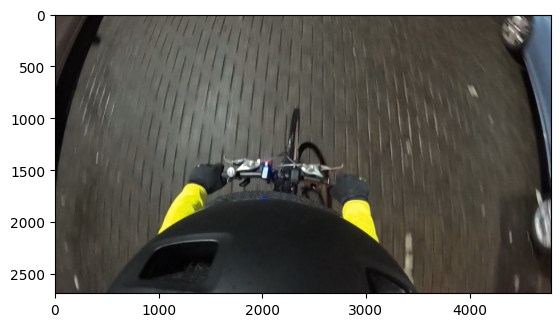

In [ ]:
sample_image = '/content/drive/MyDrive/cyclist /two/_018.jpeg'
plt.imshow(plt.imread(sample_image))



In [ ]:
class Data_Process():
  def __init__ (self,file_path):
    self.file_path = file_path

  def img_process(self):
    data = []
    IMG_SIZE = 224
    categories = ["left", "no_hand","right","single","two"]
    for category in categories:
        path_link = os.path.join(self.file_path, category)
        label = categories.index(category)
        # print(label)
        for image in os.listdir(path_link):
            try:
                img_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, label])
            except Exception as e:
                print(e)
    # print(data)
    return data

  def Data_split(self):
    x = []
    y = []
    integrate = self.img_process()
    for feature, label in np.array(integrate):
        x.append(feature)
        y.append(label)
    X = np.array(x)
    X = X.reshape(-1, 224, 224, 3)

    label_bin = LabelBinarizer()
    y = label_bin.fit_transform(y)
    Y = np.array(y)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.2)
    X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, random_state=42, test_size=0.2)

    train_generator = ImageDataGenerator(rescale=1/255, horizontal_flip=False, rotation_range=10,width_shift_range=0.2,
                                   shear_range=0.2,
                                   fill_mode="nearest",
                                   zoom_range=0.2)
    val_generator = ImageDataGenerator(rescale=1/255)
    test_generator = ImageDataGenerator(rescale=1/255)

    train_generator = train_generator.flow(np.array(X_train), Y_train, shuffle=True)
    val_generator = val_generator.flow(np.array(X_validate), Y_validate, shuffle=True)
    test_generator = test_generator.flow(np.array(X_test), Y_test, shuffle=False)

    return  train_generator, val_generator, test_generator, X_test, Y_test




In [ ]:
class Network():
  def __init__(self,pre_model,train_generator,val_generator):
        self.pre_model = pre_model
        self.train_generator = train_generator
        self.val_generator = val_generator

  def build(self):
    base_model = self.pre_model
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(5, activation='softmax')(x)

    return x


In [ ]:
f_path = '/content/drive/MyDrive/cyclist '


In [ ]:
train_generator,val_generator, test_generator, X_test, Y_test = Data_Process(f_path).Data_split()
print(len(train_generator),len(val_generator),len(test_generator))

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

6 2 2


<ipython-input-19-06e9dcc03104>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for feature, label in np.array(integrate):


In [ ]:
len(X_test)

51

In [ ]:
base_model = tf.keras.applications.MobileNet(
    input_shape = INPUT_SHAPE,
    weights = 'imagenet',
    include_top=False,
    alpha = 0.25
)

In [ ]:
base_model.summary()

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_5')>

In [ ]:
output = Network(base_model,train_generator,val_generator).build()

In [ ]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='best_model.hdf5',
                               monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce = ReduceLROnPlateau(monitor='accuracy', patience=10,
                           verbose=1,
                           factor=0.5,
                           min_lr=1e-6)

In [ ]:
best_model = Model(inputs=base_model.input, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
best_model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
history = best_model.fit(train_generator, batch_size = 5,epochs = 50, validation_data=val_generator, shuffle=True, validation_steps=len(val_generator),callbacks=[checkpointer, reduce])




Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 9.5045 - accuracy: 0.3313 
Epoch 00001: val_accuracy improved from -inf to 0.26829, saving model to best_model.hdf5
6/6 [==============================] - 21s 651ms/step - loss: 9.5045 - accuracy: 0.3313 - val_loss: 7.3658 - val_accuracy: 0.2683 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 3.5524 - accuracy: 0.5031
Epoch 00002: val_accuracy improved from 0.26829 to 0.60976, saving model to best_model.hdf5
6/6 [==============================] - 3s 416ms/step - loss: 3.5524 - accuracy: 0.5031 - val_loss: 1.8869 - val_accuracy: 0.6098 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 1.0915 - accuracy: 0.7055
Epoch 00003: val_accuracy did not improve from 0.60976
6/6 [==============================] - 4s 679ms/step - loss: 1.0915 - accuracy: 0.7055 - val_loss: 3.0747 - val_accuracy: 0.4634 - lr: 0.0010
Epoch 4/50
5/6 [========================>.....] - ETA: 0s - 

# 新段落

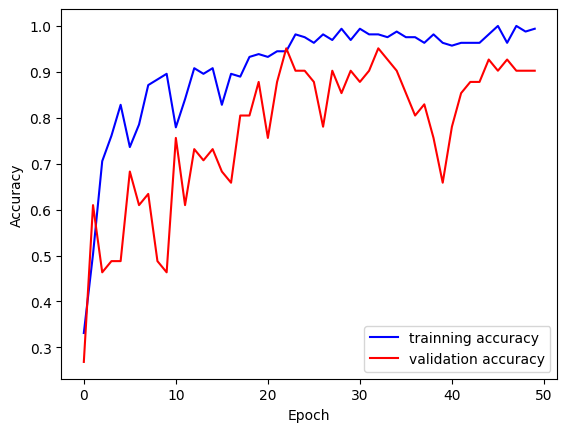

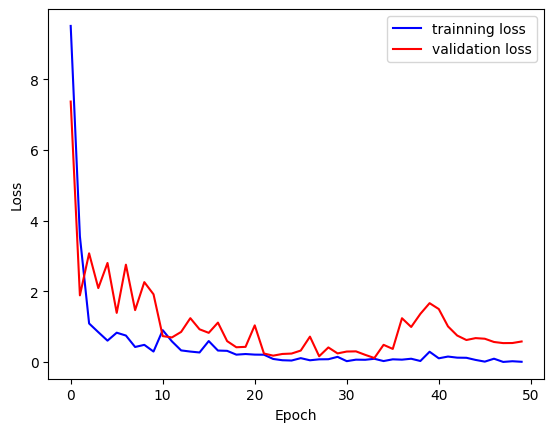

In [ ]:

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
labels_new = ["left", "no_hand","right","single",'two']
IMG_SIZE = 224
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

1/1 [==============================] - 0s 473ms/step
This is hand of two with confidence of 0.99952173


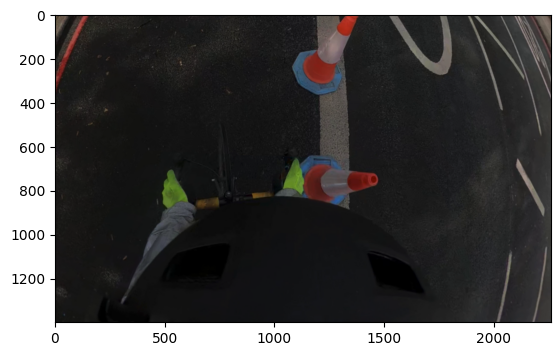

In [ ]:
t_image = '/content/drive/MyDrive/cyclist /test/t5.png'
prediction = best_model.predict([prepare(t_image)])
plt.imshow(plt.imread(t_image))
np.argmax(prediction)

print("This is hand of "+labels_new[np.argmax(prediction)]+' with confidence of '+str(prediction[0][np.argmax(prediction)]))
# for i in prediction:
#   for j in i:
#     print(float(j))

In [ ]:
results = best_model.evaluate(test_generator, verbose=0)
print(results)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

[0.8387016654014587, 0.8627451062202454]
    Test Loss: 0.83870
Test Accuracy: 86.27%


In [ ]:
prediction = best_model.predict(test_generator)
np.argmax(prediction,axis=1)

2/2 [==============================] - 1s 12ms/step


array([3, 0, 1, 4, 2, 3, 3, 4, 0, 0, 3, 4, 4, 1, 3, 1, 1, 0, 2, 0, 4, 0,
       2, 3, 0, 2, 0, 4, 0, 3, 3, 2, 3, 3, 3, 0, 2, 0, 1, 3, 3, 3, 4, 3,
       1, 1, 0, 1, 3, 3, 3])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(prediction,axis=1), target_names=labels_new))

              precision    recall  f1-score   support

        left       0.92      1.00      0.96        11
     no_hand       0.75      1.00      0.86         6
       right       1.00      1.00      1.00         6
      single       0.83      0.88      0.86        17
         two       0.86      0.55      0.67        11

    accuracy                           0.86        51
   macro avg       0.87      0.89      0.87        51
weighted avg       0.87      0.86      0.85        51



In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

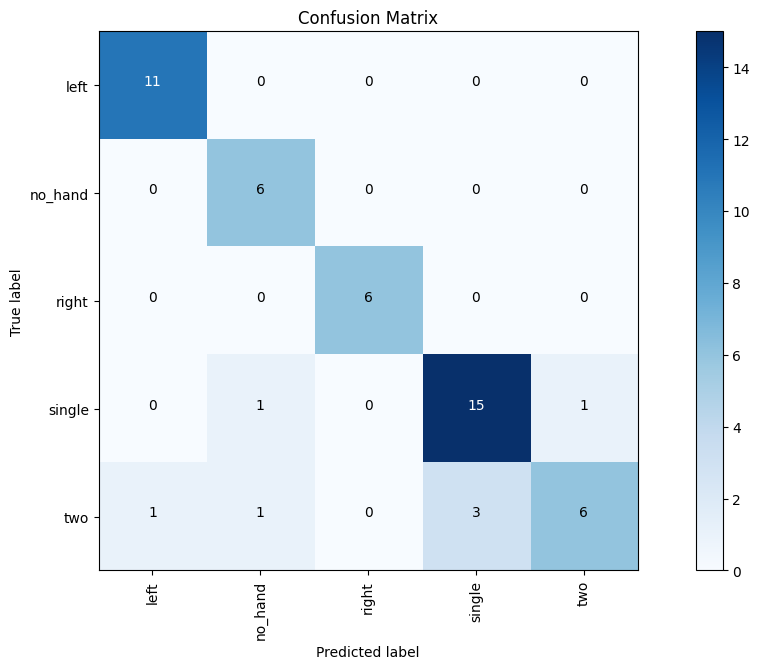

In [ ]:
from sklearn import metrics
import itertools
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
make_confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(prediction,axis=1), list(labels_new))
# plot_confusion_matrix(np.argmax(Y_test, axis=1),np.argmax(prediction,axis=1),best_model)

In [ ]:
best_model.save("2_cyclist.model.h5")